# Cardiovascular Disease Prediction

## Data description  

Data taken from: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset/data

There are 3 types of input features:

Objective: factual information;  
Examination: results of medical examination;  
Subjective: information given by the patient.  

12 Features:

1. Age | Objective Feature | age | int (days)  
2. Height | Objective Feature | height | int (cm) |  
3. Weight | Objective Feature | weight | float (kg) |  
4. Gender | Objective Feature | gender | categorical code |  
5. Systolic blood pressure | Examination Feature | ap_hi | int |  
6. Diastolic blood pressure | Examination Feature | ap_lo | int |  
7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |  
8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |  
9. Smoking | Subjective Feature | smoke | binary |  
10. Alcohol intake | Subjective Feature | alco | binary |  
11. Physical activity | Subjective Feature | active | binary |  
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 

All of the dataset values were collected at the moment of medical examination.

The dataset consists of 70 000 records of patients data. The target class "cardio" equals to 1, when patient has cardiovascular desease, and it's 0, if patient is healthy.
The task is to predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

Most of the code was taken from https://www.kaggle.com/benanakca/cardiovascular-disease-prediction

In [1]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import scipy.stats as stats
import sklearn
import os
import warnings
warnings.filterwarnings('ignore')

/Users/HuongGiangTran/miniconda3/envs/py3iaml/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


## EDA

In [2]:
# Load the data and first few rows
data_raw = pd.read_csv("cardio.csv", sep=";")
data_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
# Further info about the data
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


All features are numerical, 12 integers and 1 decimal number (weight). The second column gives us an idea how big is the dataset and how many non-null values are there for each field.

In [4]:
# Dropping useless column
data_raw.drop("id",axis=1,inplace=True)

### Checking Duplication and Missing Values

Before visualization and outlier checks it is very important to handle duplicate and missing values.

In [5]:
print("There is {} duplicated values in data frame".format(data_raw.duplicated().sum()))

There is 24 duplicated values in data frame


In [6]:
duplicated = data_raw[data_raw.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['age', "gender", "height"], ascending= False) 
# Sort the values to see duplication clearly

duplicated.head(2) # Show 1 duplication out of 24

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2677,22077,1,175,69.0,120,80,1,1,0,0,1,1
45748,22077,1,175,69.0,120,80,1,1,0,0,1,1


We can drop the duplicates because they have no any effect of training of model.

In [7]:
data_raw.drop_duplicates(inplace=True)
print("There is {} duplicated values in data frame".format(data_raw.duplicated().sum()))

There is 0 duplicated values in data frame


In [8]:
print("There is {} missing values in data frame".format(data_raw.isnull().sum().sum()))

There is 0 missing values in data frame


### Visualization 

Detecting outlier and handling them can increase our accuracy score.

In [9]:
x = data_raw.copy(deep=True)
x.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Columns of "age", "height", "weight", "ap_hi", "ap_lo" may have outlier. In order to compare them on same scale we need to standartize firstly.

##### Their Standart Scalar Function

In [10]:
s_list = ["age", "height", "weight", "ap_hi", "ap_lo"]
def standartization(x):
    x_std = x.copy(deep=True)
    for column in s_list:
        x_std[column] = (x_std[column]-x_std[column].mean())/x_std[column].std()
    return x_std 
x_std=standartization(x)
x_std.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,-0.436071,2,0.443399,-0.847978,-0.122181,-0.088254,1,1,0,0,1,0
1,0.307635,1,-1.018016,0.749554,0.072577,-0.035205,3,1,0,0,1,1
2,-0.248017,1,0.078045,-0.709062,0.007658,-0.141303,3,1,0,0,0,1
3,-0.748143,2,0.565184,0.541180,0.137496,0.017844,1,1,0,0,1,1
4,-0.808532,1,-1.018016,-1.264725,-0.187100,-0.194352,1,1,0,0,0,0


In order to use the multi box graph plot we need to melt out data.

In [11]:
x_melted = pd.melt(frame=x_std, id_vars="cardio", value_vars=s_list, var_name="features", value_name="value", col_level=None)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

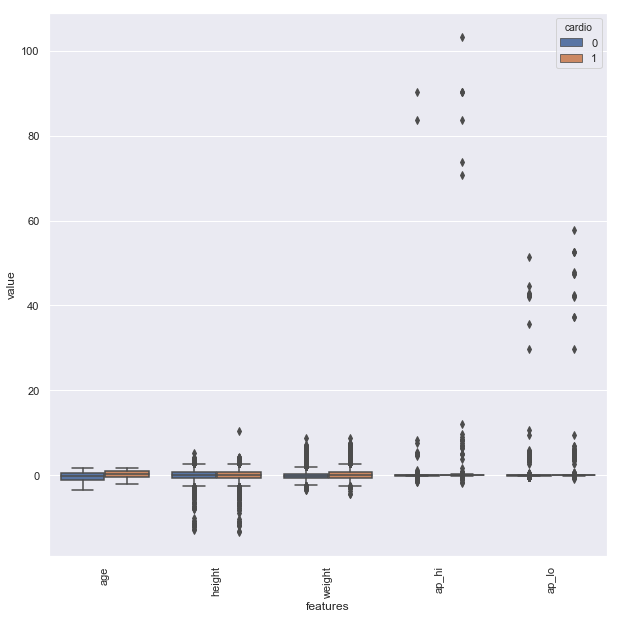

In [12]:
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="cardio", data=x_melted)
plt.xticks(rotation=90)

There are some outliers in the dataset, but as seen above there is an unusual outlier in ap_hi and ap_lo features.

Let us calculate the low bound and high bound of ap_lo and ap_hi features.

In [13]:
ap_list = ["ap_hi", "ap_lo"]
boundary = pd.DataFrame(index=["lower_bound","upper_bound"]) # We created an empty dataframe
for each in ap_list:
    Q1 = x[each].quantile(0.25)
    Q3 = x[each].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1- 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    boundary[each] = [lower_bound, upper_bound ]
boundary

,ap_hi,ap_lo
lower_bound,90.0,65.0
upper_bound,170.0,105.0


We can select the index of outlier data by using boundaries we calculated. Normally we should analyze both upper outliers and below outliers but in this case, they considered to handle just uppers because of their extremely higher values.

In [14]:
ap_hi_filter = (x["ap_hi"] > boundary["ap_hi"][1])
ap_lo_filter = (x["ap_lo"] > boundary["ap_lo"][1])                                                           
outlier_filter = (ap_hi_filter | ap_lo_filter)
x_outliers = x[outlier_filter]
x_outliers["cardio"].value_counts()

1    2025
0     388
Name: cardio, dtype: int64

Cardiovascular disease is present in 83 percent of the ap_hi and ap_lo outlier data. Because of ap_hi and ap_lo symbolizes high blood pressure, the high rate of disease is consistent with real life. For this reason, we drop medically impossible data from the dataset.

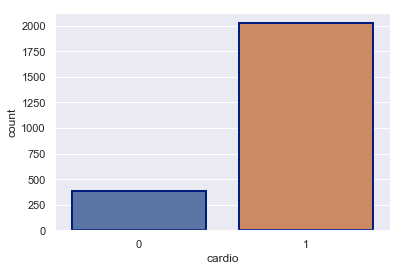

In [15]:
sns.countplot(x='cardio',data=x_outliers,linewidth=2,edgecolor=sns.color_palette("dark", 1))

"If one’s systolic pressure (ap_hi) exceeds 180 or diastolic pressure (ap_lo) crosses 120, it is a stage that requires immediate medical attention." A study published by doctors in NCBI NLM recorded a maximum blood pressure of 370/360 mm Hg. This study was performed by recording blood pressure in 10 male athletes through radial artery catheterization. Thus we can drop the ap_hi outlier values over 250 and ap_lo outlier values over 200, without fear of missing data.

In [16]:
out_filter = ((x["ap_hi"]>250) | (x["ap_lo"]>200) )
print("There are {} outliers".format(x[out_filter]["cardio"].count()))

There are 993 outliers


In [17]:
x = x[~out_filter]

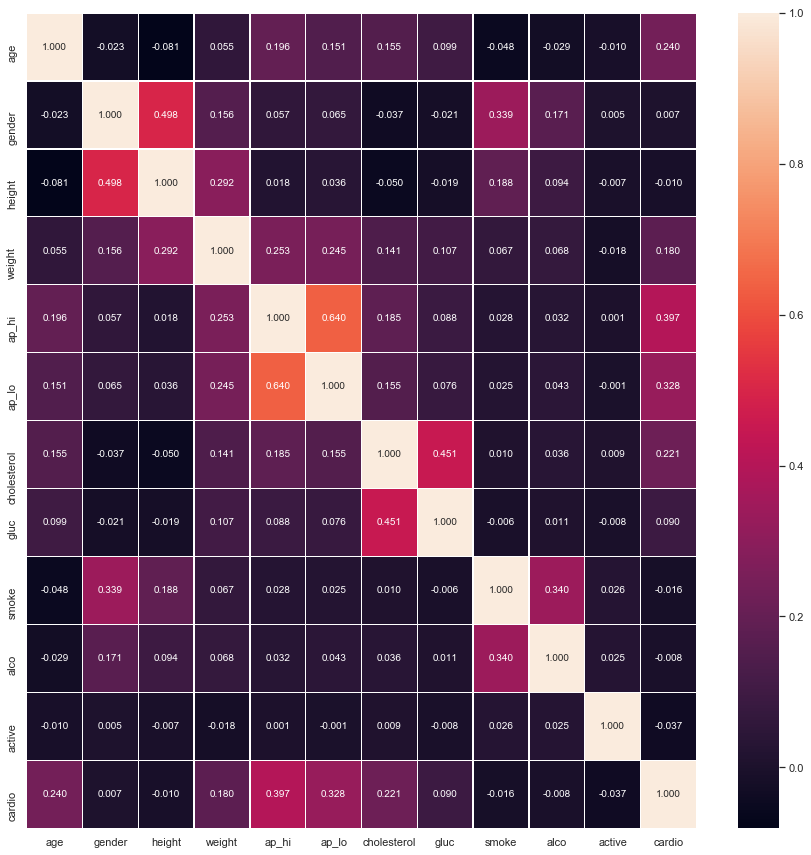

In [18]:
corr = x.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)

We can see from correlation map easily; cholesterol, blood pressure (ap_hi and ap_low both) and age have a powerful relationship with cardiovascular diseases. Glucogen and cholesterol have a strong relationship among them.

### Feature Engineering 

In [19]:
# Height and weight seems uncorrelated with the cardio feature
# but Body Mass Index could be helpful to train our model.

def bmi_calc(w, h):
    return w/(h**2)

In [20]:
x["bmi"] = x["weight"]/ (x["height"]/100)**2

In [21]:
x.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


In [22]:
# Detecting genders of patients

a = x[x["gender"]==1]["height"].mean()
b = x[x["gender"]==2]["height"].mean()
if a > b:
    gender = "male"
    gender2 = "female"
else:
    gender = "female"
    gender2 = "male"
print("Gender:1 is "+ gender +" & Gender:2 is " + gender2)

Gender:1 is female & Gender:2 is male


Women have many of the same risk factors with men for heart disease as men, such as smoking, high blood pressure, and high cholesterol especially after 65. Thus we shouldn't categorize them into 1 and 2 because of 2 is always numerically bigger than 1, the model would take into account that and give a bigger ratio to men for having a disease. We did not change other categorical code to one hot encoding because they express really hierarchical size. An example from describtion of dataset : Cholesterol | 1: normal, 2: above normal, 3: well above normal

In [23]:
x["gender"] = x["gender"] % 2
x["gender"].head()

0    0
1    1
2    1
3    0
4    1
Name: gender, dtype: int64

(array([0, 1]), <a list of 2 Text xticklabel objects>)

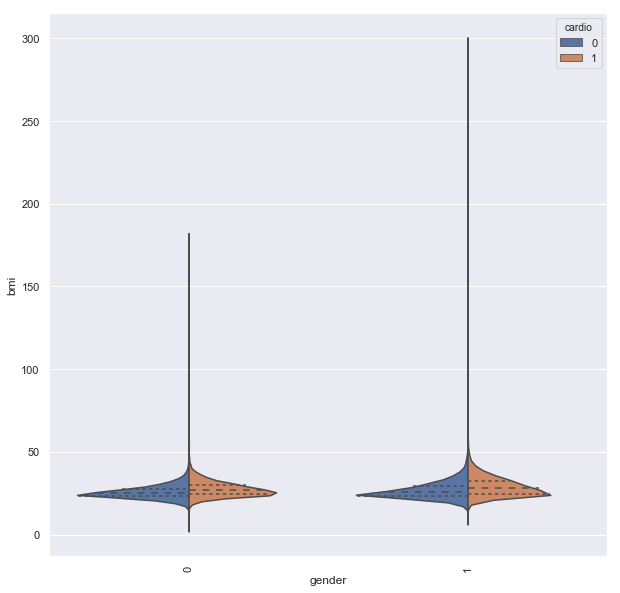

In [24]:
from sklearn.preprocessing import StandardScaler
x_std = standartization(x)

data = pd.melt(x_std,id_vars="cardio",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="gender", y="bmi", hue="cardio", data=x,split=True, inner="quart")
plt.xticks(rotation=90)

If we interpret the violin plot, the median and quartiles of bmi distribution of patients is slightly higher than non-patients.

### Preparing the Training and Test Sets

In [25]:
y = x["cardio"]
y.shape

(68983,)

In [26]:
x.drop("cardio", axis=1,inplace=True)
x.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
0,18393,0,168,62.0,110,80,1,1,0,0,1,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,23.507805
3,17623,0,169,82.0,150,100,1,1,0,0,1,28.710479
4,17474,1,156,56.0,100,60,1,1,0,0,0,23.011177


In [27]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

### Data Normalization 

In [28]:
from sklearn.preprocessing import normalize
x_train = normalize(x_train)
x_test = normalize(x_test)
x = normalize(x)

## Machine Learning Models

### Random Guess

In [29]:
data_size = x.shape[0]
is_positive = np.sum(y == 1)/data_size #probability that y=1
is_negative = np.sum(y == 0)/data_size

# Accuracy
print("Accuracy is", '%.03f' %is_negative)

# AUROC
print("AUROC is 0.5")

#AUPRC
print("AUPRC is", '%.03f' %is_positive)

Accuracy is 0.505
AUROC is 0.5
AUPRC is 0.495


### DT, Random Forest, kNN, SVM, NB and Logistic Regression

In [30]:
# finding the best parameters for logistic regression using grid search
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42,solver="liblinear", max_iter=200)
grid = {"penalty" : ["l1", "l2"],
         "C" : np.arange(60,80,2)} # (60,62,64 ... 78)
log_reg_cv = GridSearchCV(log_reg, grid, cv=3)
log_reg_cv.fit(x_train, y_train)

# Print hyperparameter
print("Tuned hyperparameter n_estimators: {}".format(log_reg_cv.best_params_)) 

Tuned hyperparameter n_estimators: {'C': 78, 'penalty': 'l1'}


In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

dec = DecisionTreeClassifier(random_state=42)
ran = RandomForestClassifier(random_state=42,n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=100)
svm = SVC(random_state=42,probability=True)
naive = GaussianNB()
lg = log_reg_cv.best_estimator_

models = {"Decision tree" : dec,
          "Random forest" : ran,
          "KNN" : knn,
          "SVM" : svm,
          "Naive bayes" : naive,
          "Logistic regression" : lg}
acc_scores = { }
auroc = { }
auprc = { }
logloss = { }
F1 = { }

for key, value in models.items():    
    model = value
    model.fit(x_train, y_train)
    acc_scores[key] = model.score(x_test, y_test)
    probs = model.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    auroc[key] = metrics.auc(fpr, tpr)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    auprc[key] = auc(recall, precision)
    predict = model.predict(x_test)
    logloss[key] = log_loss(y_test, probs)
    F1[key] = f1_score(y_test, predict)

#### Table of scores:

In [32]:
scores_frame = pd.DataFrame([acc_scores,auroc,auprc,logloss,F1],
                            index=["Accuracy Score", "AUROC","AUPRC", "log_loss", "F1"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
scores_frame

,Accuracy Score,AUROC,AUPRC,log_loss,F1
Logistic regression,0.724330,0.788069,0.765867,0.568128,0.708050
Random forest,0.717613,0.777489,0.759692,0.580757,0.708616
KNN,0.716067,0.775914,0.758858,0.567761,0.692646
Naive bayes,0.640445,0.707892,0.664219,0.701997,0.577000
Decision tree,0.632133,0.632115,0.718344,12.700925,0.627599
SVM,0.508529,0.740736,0.721336,0.672667,0.000000


### ROC and PR curves for each classifier

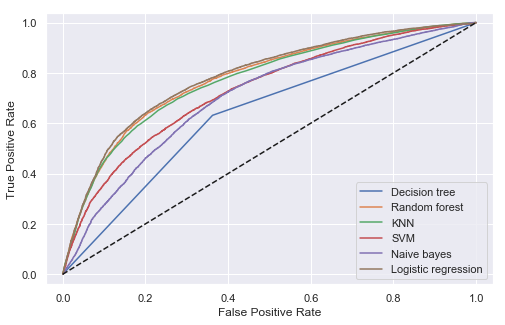

In [34]:
for key, value in models.items(): 
    probs = value.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = '{}'.format(key))
    
plt.legend()
plt.rcParams["figure.figsize"] = (8,5)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.04, 1.04])
plt.ylim([-0.04, 1.04])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('cardio_ROCcurve.png')
plt.show()

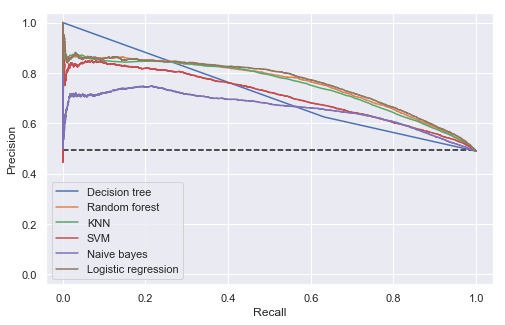

In [33]:
for key, value in models.items(): 
    probs = value.predict_proba(x_test)
    preds = probs[:,1]    
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    plt.plot(recall, precision, label = '{}'.format(key))
    
plt.hlines(is_positive, 0, 1, colors = 'k', linestyle = 'dashed')
plt.legend()
plt.rcParams["figure.figsize"] = (8,5)
plt.xlim([-0.04, 1.04])
plt.ylim([-0.04, 1.04])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig('cardio_PRcurve.png')
plt.show()